# Assignment 4 -  Recurrent Neural Networks(RNN) and English Text Character Synthesis

## Libraries and Imports

In [1]:
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

## Data

In [2]:
book_path = "./data/goblet_book.txt"
with open(book_path, "r", encoding="utf-8") as f:
    book_data = f.read()

In [3]:
print(f"{book_data[:100]}")

HARRY POTTER AND THE GOBLET OF FIRE

CHAPTER ONE - THE RIDDLE HOUSE

	The villagers of Little Hangle


## Exercise 1 - Implement and train vanilla RNN 

### 1.1 - Load Data

In [4]:
unique_chars = list(set(book_data))
char_to_id = {char: i for i, char in enumerate(unique_chars)}
id_to_char = {i: char for i, char in enumerate(unique_chars)}

In [5]:
print(f"char -> id: {char_to_id}")

char -> id: {'(': 0, 'c': 1, ';': 2, '6': 3, 'f': 4, 'j': 5, 'X': 6, 'x': 7, '?': 8, 'u': 9, 'y': 10, '•': 11, 'G': 12, '-': 13, 'E': 14, 'Y': 15, '2': 16, 'D': 17, 'F': 18, '!': 19, '0': 20, ':': 21, 'p': 22, 'd': 23, 'o': 24, 'V': 25, ' ': 26, 'i': 27, '_': 28, 'h': 29, 'Z': 30, 'w': 31, 'k': 32, 'O': 33, '1': 34, '\t': 35, 'C': 36, 'U': 37, 'R': 38, 'z': 39, 'e': 40, 'ü': 41, 'M': 42, 'n': 43, 'W': 44, 'a': 45, ',': 46, 'B': 47, 'r': 48, '9': 49, 's': 50, 't': 51, ')': 52, 'T': 53, 'J': 54, 'K': 55, 'l': 56, 'S': 57, '.': 58, '^': 59, '}': 60, 'q': 61, 'm': 62, 'L': 63, 'N': 64, 'P': 65, '7': 66, 'A': 67, '4': 68, '3': 69, 'v': 70, '/': 71, 'g': 72, '\n': 73, 'I': 74, 'H': 75, '"': 76, 'Q': 77, 'b': 78, "'": 79}


In [6]:
print(f"char <- id: {id_to_char}")

char <- id: {0: '(', 1: 'c', 2: ';', 3: '6', 4: 'f', 5: 'j', 6: 'X', 7: 'x', 8: '?', 9: 'u', 10: 'y', 11: '•', 12: 'G', 13: '-', 14: 'E', 15: 'Y', 16: '2', 17: 'D', 18: 'F', 19: '!', 20: '0', 21: ':', 22: 'p', 23: 'd', 24: 'o', 25: 'V', 26: ' ', 27: 'i', 28: '_', 29: 'h', 30: 'Z', 31: 'w', 32: 'k', 33: 'O', 34: '1', 35: '\t', 36: 'C', 37: 'U', 38: 'R', 39: 'z', 40: 'e', 41: 'ü', 42: 'M', 43: 'n', 44: 'W', 45: 'a', 46: ',', 47: 'B', 48: 'r', 49: '9', 50: 's', 51: 't', 52: ')', 53: 'T', 54: 'J', 55: 'K', 56: 'l', 57: 'S', 58: '.', 59: '^', 60: '}', 61: 'q', 62: 'm', 63: 'L', 64: 'N', 65: 'P', 66: '7', 67: 'A', 68: '4', 69: '3', 70: 'v', 71: '/', 72: 'g', 73: '\n', 74: 'I', 75: 'H', 76: '"', 77: 'Q', 78: 'b', 79: "'"}


### 1.2 - Neural Network Architecture

In [7]:
def initialize_network(hidden_dim, output_dim, rng):
    init_net = {}
    init_net["b"] = np.zeros((hidden_dim, 1))
    init_net["c"] = np.zeros((output_dim, 1))

    init_net["U"] = (1 / np.sqrt(2 * output_dim)) * rng.standard_normal(
        size=(hidden_dim, output_dim)  # mxk
    )
    init_net["W"] = (1 / np.sqrt(2 * hidden_dim)) * rng.standard_normal(
        size=(hidden_dim, hidden_dim)  # mxm
    )
    init_net["V"] = (1 / np.sqrt(hidden_dim)) * rng.standard_normal(
        size=(output_dim, hidden_dim)  # kxm
    )
    return init_net

In [8]:
def init_network():
    eta = 0.001
    seq_length = 25
    m = 100
    K = len(unique_chars)
    seed = 42
    rng = np.random.default_rng(seed=seed)
    init_net = initialize_network(m, K, rng)
    return init_net

In [9]:
debug_init_net = init_network()
print("initialize network...")
print(f"init_network[U] shape -> {debug_init_net['U'].shape}")
print(f"init_network[W] shape -> {debug_init_net['W'].shape}")
print(f"init_network[V] shape -> {debug_init_net['V'].shape}")
print(f"init_network[b] shape -> {debug_init_net['b'].shape}")
print(f"init_network[c] shape -> {debug_init_net['c'].shape}")

initialize network...
init_network[U] shape -> (100, 80)
init_network[W] shape -> (100, 100)
init_network[V] shape -> (80, 100)
init_network[b] shape -> (100, 1)
init_network[c] shape -> (80, 1)


### 1.3 - Generalization

In [10]:
"""
Activation functions.
"""


# softmax function - not numerically stable according to stanford cs231n notes
def softmax(s):
    return np.exp(s) / np.sum(np.exp(s), axis=0)

In [11]:
def synthesize_text(network, h0, x0, n, rng):
    K = network["V"].shape[0]
    Y = np.zeros((K, n))

    h = h0.copy()
    x = x0.copy()

    for t in range(n):
        a = network["W"] @ h + network["U"] @ x + network["b"]
        h = np.tanh(a)
        o = network["V"] @ h + network["c"]
        p = softmax(o)

        cp = np.cumsum(p, axis=0)
        a = rng.uniform(size=1)
        ii = np.argmax(cp - a > 0)

        Y[ii, t] = 1

        x = np.zeros((K, 1))
        x[ii, 0] = 1

    return Y

In [12]:
def encode_chars(chars, char_to_id, K):
    X = np.zeros((K, len(chars)))
    for i, char in enumerate(chars):
        if char in char_to_id:
            X[char_to_id[char], i] = 1
    return X

In [13]:
def decode_chars(Y, ind_to_char):
    indices = np.argmax(Y, axis=0)
    text = "".join([ind_to_char[index] for index in indices])
    return text

In [14]:
def forward(network, X, Y, h0):
    K, seq_length = X.shape
    m = network["W"].shape[0]

    h = np.zeros((m, seq_length + 1))
    p = np.zeros((K, seq_length))

    h[:, 0:1] = h0
    loss = 0

    for t in range(seq_length):
        x_t = X[:, t : t + 1]
        h_prev = h[:, t : t + 1]
        a_t = network["W"] @ h_prev + network["U"] @ x_t + network["b"]
        h[:, t + 1 : t + 2] = np.tanh(a_t)
        o_t = network["V"] @ h[:, t + 1 : t + 2] + network["c"]
        p_t = softmax(o_t)
        p[:, t : t + 1] = p_t

        y_t = Y[:, t : t + 1]
        loss += -np.sum(y_t * np.log(p_t + 1e-20))

    loss = loss / seq_length

    return loss, h, p

In [15]:
def backward(network, X, Y, h, p):
    K, seq_length = X.shape
    m = network["W"].shape[0]
    grads = {}
    grads["dU"] = np.zeros_like(network["U"])  # m × K
    grads["dW"] = np.zeros_like(network["W"])  # m × m
    grads["dV"] = np.zeros_like(network["V"])  # K × m
    grads["db"] = np.zeros_like(network["b"])  # m × 1
    grads["dc"] = np.zeros_like(network["c"])  # K × 1

    # initialize gradient for next time step
    dh_next = np.zeros((m, 1))

    for t in reversed(range(seq_length)):
        y_t = Y[:, t : t + 1]
        p_t = p[:, t : t + 1]
        h_t = h[:, t + 1 : t + 2]
        h_prev = h[:, t : t + 1]
        x_t = X[:, t : t + 1]

        # gradient of output
        d_out = p_t - y_t

        # gradient of v
        grads["dV"] += d_out @ h_t.T

        # gradient of c
        grads["dc"] += d_out

        # gradient of hidden
        d_h = network["V"].T @ d_out + dh_next

        # gradient of a
        d_a = d_h * (1 - h_t**2)

        # gradient of W
        grads["dW"] += d_a @ h_prev.T

        # gradient of U
        grads["dU"] += d_a @ x_t.T

        # gradient of B
        grads["db"] += d_a

        # gradient for next iteration
        dh_next = network["W"].T @ d_a

    for key in grads:
        grads[key] /= seq_length

    return grads

In [16]:
# assumes X has size d x tau, h0 has size m x 1, etc
def ComputeGradsWithTorch(X, y, h0, RNN):
    tau = X.shape[1]

    Xt = torch.from_numpy(X)
    ht = torch.from_numpy(h0)

    torch_network = {}
    for kk in RNN.keys():
        torch_network[kk] = torch.tensor(RNN[kk], requires_grad=True)

    ## give informative names to these torch classes
    apply_tanh = torch.nn.Tanh()
    apply_softmax = torch.nn.Softmax(dim=0)

    # create an empty tensor to store the hidden vector at each timestep
    Hs = torch.empty(h0.shape[0], X.shape[1], dtype=torch.float64)

    hprev = ht
    for t in range(tau):
        #### BEGIN your code ######

        # Code to apply the RNN to hprev and Xt[:, t:t+1] to compute the hidden scores "Hs" at timestep t
        x_t = Xt[:, t : t + 1]  # kx1

        # (ie equations (1,2) in the assignment instructions)
        a_t = (
            torch.matmul(torch_network["W"], hprev)
            + torch.matmul(torch_network["U"], x_t)
            + torch_network["b"]
        )

        h_t = apply_tanh(a_t)

        # Store results in Hs
        Hs[:, t : t + 1] = h_t

        # Don't forget to update hprev!
        hprev = h_t

        #### END of your code ######

    Os = torch.matmul(torch_network["V"], Hs) + torch_network["c"]
    P = apply_softmax(Os)

    # compute the loss

    loss = torch.mean(-torch.log(P[y, np.arange(tau)]))

    # compute the backward pass relative to the loss and the named parameters
    loss.backward()

    # extract the computed gradients and make them numpy arrays
    grads = {}
    for kk in RNN.keys():
        grads[kk] = torch_network[kk].grad.numpy()

    return grads

### 1.4 - Neural Networks go brrrr.... 

In [17]:
def small_network():
    rng = np.random.default_rng(42)
    seq_length = 25
    m = 10
    X_chars = book_data[0:seq_length]
    Y_chars = book_data[1 : seq_length + 1]
    K = len(unique_chars)
    X = encode_chars(X_chars, char_to_id, K)
    Y = encode_chars(Y_chars, char_to_id, K)
    h0 = np.zeros((m, 1))

    init_net = initialize_network(m, K, rng)
    loss, h, p = forward(init_net, X, Y, h0)
    print(
        f"forward pass -> Loss: {loss:.4f} | h_shape: {h.shape} | p_shape: {p.shape}"
    )

    y_indices = np.argmax(encode_chars(Y_chars, char_to_id, K), axis=0)
    torch_grads = ComputeGradsWithTorch(X, y_indices, h0, init_net)
    grads = backward(init_net, X, Y, h, p)

    return torch_grads, grads

In [18]:
def absolute_error_check():
    eps = 1e-6
    torch_grads, my_grads = small_network()
    abs_error_U = np.abs(my_grads["dU"] - torch_grads["U"])
    abs_error_W = np.abs(my_grads["dW"] - torch_grads["W"])
    abs_error_V = np.abs(my_grads["dV"] - torch_grads["V"])
    abs_error_b = np.abs(my_grads["db"] - torch_grads["b"])
    abs_error_c = np.abs(my_grads["dc"] - torch_grads["c"])
    print(f"U gradient check -> {np.all(abs_error_U < eps)}")
    print(f"W gradient check -> {np.all(abs_error_W < eps)}")
    print(f"V gradient check -> {np.all(abs_error_V < eps)}")
    print(f"b gradient check -> {np.all(abs_error_b < eps)}")
    print(f"c gradient check -> {np.all(abs_error_c < eps)}")

In [19]:
absolute_error_check()

forward pass -> Loss: 4.3681 | h_shape: (10, 26) | p_shape: (80, 25)
U gradient check -> True
W gradient check -> True
V gradient check -> True
b gradient check -> True
c gradient check -> True


In [20]:
def plot_loss(loss_history, iter_history, filename=None):
    plt.figure(figsize=(12, 6))
    plt.plot(iter_history, loss_history)
    plt.xlabel("Number of Iterations")
    plt.ylabel("Smooth Loss")
    plt.title("Smooth Loss - 4 Epochs")
    plt.grid(True, alpha=0.3)

    if filename:
        plt.savefig(f"{filename}.png", dpi=300, bbox_inches="tight")
    plt.show()

In [21]:
def print_text_history(text_samples, filename="text_evolution.txt"):
    with open(filename, "w", encoding="utf-8") as f:
        for sample in text_samples:
            f.write(
                f"Iteration: {sample['iteration']} | Smooth Loss: {sample['loss']:.4f}\n"
            )
            f.write(f"{sample['text']}\n\n")

In [22]:
def print_final_text(network, char_to_id, id_to_char, rng, length=1000):
    K = len(char_to_id)
    hidden_dim = network["W"].shape[0]
    h0 = np.zeros((hidden_dim, 1))
    x0 = np.zeros((K, 1))
    x0[0, 0] = 1
    Y_synth = synthesize_text(network, h0, x0, length, rng)
    return decode_chars(Y_synth, id_to_char)

In [23]:
def train_rnn(
    book_data,
    char_to_id,
    id_to_char,
    network,
    rng,
    eta=0.001,
    seq_length=25,
    num_epochs=2,
):
    adam_params = {}
    for key in network.keys():
        adam_params[key] = {
            "m": np.zeros_like(network[key]),
            "v": np.zeros_like(network[key]),
            "t": 0,
        }

    # adam hyperparameters
    beta1 = 0.9
    beta2 = 0.999
    epsilon = 1e-8

    e = 0
    smooth_loss = None
    hprev = np.zeros((network["W"].shape[0], 1))
    update = 0
    K = len(unique_chars)

    loss_history = []
    iter_history = []
    text_samples = []

    best_smooth_loss = float("inf")
    best_network = None
    best_update = 0

    print("TRAIN THE RNN..............")
    for epoch in range(num_epochs):
        print(f"Epoch: {epoch + 1}")
        while e <= len(book_data) - seq_length - 1:
            X_chars = book_data[e : e + seq_length]
            Y_chars = book_data[e + 1 : e + seq_length + 1]

            X = encode_chars(X_chars, char_to_id, K)
            Y = encode_chars(Y_chars, char_to_id, K)

            loss, h, p = forward(network, X, Y, hprev)

            if smooth_loss is None:
                smooth_loss = loss
            else:
                smooth_loss = 0.999 * smooth_loss + 0.001 * loss

            if smooth_loss < best_smooth_loss:
                best_smooth_loss = smooth_loss
                best_network = copy.deepcopy(network)
                best_update = update
                print(
                    f"Best model at iteration: {update} | smooth loss: {smooth_loss:.5f}"
                )

            grads = backward(network, X, Y, h, p)

            for key in network.keys():
                adam_params[key]["t"] += 1
                t = adam_params[key]["t"]
                adam_params[key]["m"] = (
                    beta1 * adam_params[key]["m"]
                    + (1 - beta1) * grads["d" + key]
                )
                adam_params[key]["v"] = beta2 * adam_params[key]["v"] + (
                    1 - beta2
                ) * (grads["d" + key] ** 2)
                m_hat = adam_params[key]["m"] / (1 - beta1**t)
                v_hat = adam_params[key]["v"] / (1 - beta2**t)
                network[key] = network[key] - eta * m_hat / (
                    np.sqrt(v_hat) + epsilon
                )

            hprev = h[:, -1:]

            if update % 100 == 0:
                loss_history.append(smooth_loss)
                iter_history.append(update)

            if update == 0 or update % 1000 == 0:
                print(f"iter = {update}, smooth loss={smooth_loss}")
                Y_synth = synthesize_text(network, hprev, X[:, 0:1], 200, rng)
                generated_text = decode_chars(Y_synth, id_to_char)
                text_samples.append(
                    {
                        "iteration": update,
                        "text": generated_text,
                        "loss": smooth_loss,
                    }
                )
                print(generated_text)
                print()

            e += seq_length
            update += 1

        print(f"Completed epoch {epoch + 1}")
        e = 0
        hprev = np.zeros((network["W"].shape[0], 1))

    print(
        f"\nBest model achieved smooth loss: {best_smooth_loss:.5f} at iteration: {best_update}"
    )

    return (
        network,
        smooth_loss,
        loss_history,
        iter_history,
        text_samples,
        best_network,
        best_smooth_loss,
    )

In [24]:
eta = 0.001
seq_length = 25
m = 100
K = len(unique_chars)
rng = np.random.default_rng(seed=42)

network = initialize_network(m, K, rng)
(
    trained_network,
    final_smooth_loss,
    final_loss_history,
    final_iter_history,
    final_text_samples,
    best_network,
    best_smooth_loss,
) = train_rnn(
    book_data,
    char_to_id,
    id_to_char,
    network,
    rng,
    eta=eta,
    seq_length=seq_length,
    num_epochs=4,
)

TRAIN THE RNN..............
Epoch: 1
Best model at iteration: 0 | smooth loss: 4.37449
iter = 0, smooth loss=4.374490016935686
/M-/.RCJ 'mtJ'(cmDKüVFm-G	ut'^Bw'vPFyE0XvEF/QFpLQt1Tm?	4lG}T:iV'Y7Mvb"4k:Vti1Xq?iBM/TLoy^•7Hp}1oOt'ol !sqSH?ndPfEm_J'UMb^YLemBFN(/PQ61Eh_r1QpkKpSSSJP'fzP(n)YwmjyPNBO?N!
qXt
3r-J)B:gzd!pCFüYp?ikw.RK;	x

Best model at iteration: 1 | smooth loss: 4.37448
Best model at iteration: 2 | smooth loss: 4.37447
Best model at iteration: 5 | smooth loss: 4.37446
Best model at iteration: 6 | smooth loss: 4.37445
Best model at iteration: 7 | smooth loss: 4.37439
Best model at iteration: 8 | smooth loss: 4.37427
Best model at iteration: 9 | smooth loss: 4.37415
Best model at iteration: 10 | smooth loss: 4.37391
Best model at iteration: 11 | smooth loss: 4.37364
Best model at iteration: 12 | smooth loss: 4.37339
Best model at iteration: 13 | smooth loss: 4.37306
Best model at iteration: 14 | smooth loss: 4.37241
Best model at iteration: 15 | smooth loss: 4.37200
Best model at i

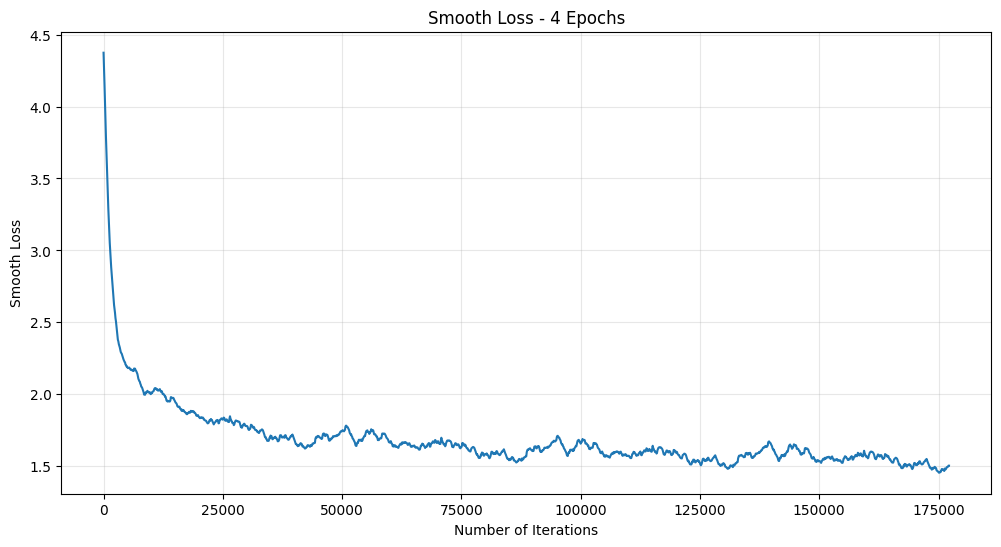

'Hersily Dumbledore told mad the membles, and Voldemy.  Hearvy arm cominnan to he will happeat I will, and with you him,  he blevany has this and can away..\n"You as the noved," though Dumbledore wanvy arming entriuted of the shoulder,"  wall toun ristange, thought who ask oned to silent ourse begoll\'s we nome bas queak of the possout thot Sirius.  Beh. He seer the doul?" said Heavion\'s were to the rese, heldem wifl arous wifl\'s a saw.  He not ques.  Some downed."  wannd unabbe you his will meet turned. S it farm.\n"Mrsalay (Fimt dven\'t every while them thought you knightly."\nThe been Harry\'s awayt offich, Bo."\n"Ithey.  Oh you know help of Dimblay behind whord tellin that whan ever Bell me betond each and a listen all rothing whan you hen spoke, Cedric into the helfing around, do said, he\'s beinxy, antiede Jome," said Deminny agair, inains, Belix," sher his heard as though when as a Swelar into the flocks thas he was get him, very noisy very toldes," said Dumbledore-lest bus; a

In [25]:
plot_loss(final_loss_history, final_iter_history, "smooth_loss_results")
print_text_history(final_text_samples)
print_final_text(best_network, char_to_id, id_to_char, rng, 1000)